In [196]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import root_mean_squared_error
import torch
import torch.nn as nn

1. Import Dataset

In [197]:
train = pd.read_csv('archive/Google_Stock_Price_Train.csv')
test = pd.read_csv('archive/Google_Stock_Price_Test.csv')

In [198]:
train['Volume'] = train['Volume'].str.replace(',', '').astype(float)
train['Close'] = train['Close'].str.replace(',', '').astype(float)
#volume and close volume were initially set to string type instead of float

In [199]:
train.describe()

,Open,High,Low,Close,Volume
count,1258.000000,1258.000000,1258.000000,1258.000000,1.258000e+03
mean,533.709833,537.880223,529.007409,712.669666,3.158107e+06
std,151.904442,153.008811,150.552807,164.752591,2.273726e+06
min,279.120000,281.210000,277.220000,491.200000,7.900000e+03
25%,404.115000,406.765000,401.765000,576.740000,1.621700e+06
50%,537.470000,540.750000,532.990000,695.675000,2.566150e+06
75%,654.922500,662.587500,644.800000,782.105000,4.122500e+06
max,816.680000,816.680000,805.140000,1216.830000,2.497790e+07


In [200]:
test['Volume'] = test['Volume'].str.replace(',','').astype(float)
#volume was initially set to string type instead of float

In [201]:
test.describe()

,Open,High,Low,Close,Volume
count,20.000000,20.000000,20.000000,20.000000,2.000000e+01
mean,807.526000,811.926500,801.949500,807.904500,1.659895e+06
std,15.125428,14.381198,13.278607,13.210088,6.774747e+05
min,778.810000,789.630000,775.800000,786.140000,9.193000e+05
25%,802.965000,806.735000,797.427500,802.282500,1.248500e+06
50%,806.995000,808.640000,801.530000,806.110000,1.418050e+06
75%,809.560000,817.097500,804.477500,810.760000,1.743400e+06
max,837.810000,841.950000,827.010000,835.670000,3.246600e+06


In [202]:
train.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,7380500.0
1,1/4/2012,331.27,333.87,329.08,666.45,5749400.0
2,1/5/2012,329.83,330.75,326.89,657.21,6590300.0
3,1/6/2012,328.34,328.77,323.68,648.24,5405900.0
4,1/9/2012,322.04,322.29,309.46,620.76,11688800.0


2. EDA and Data Preprocessing

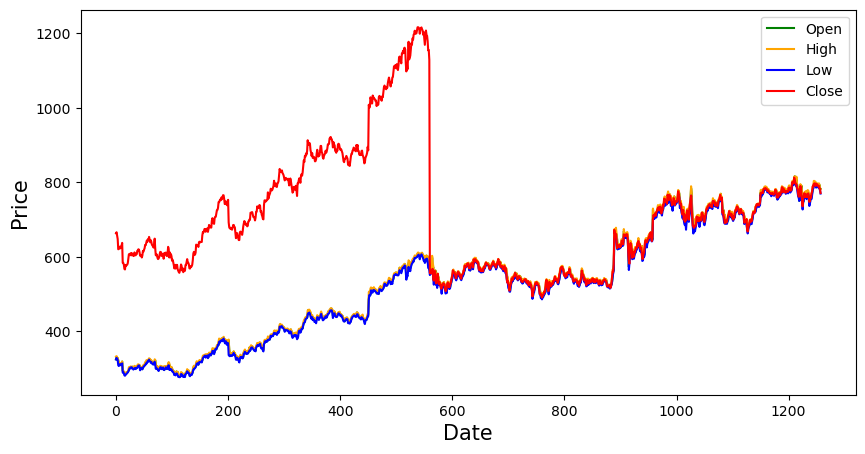

In [203]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train['Open'], label='Open', color='green')
ax.plot(train['High'], label='High', color='orange')
ax.plot(train['Low'],label='Low',color='blue')
ax.plot(train['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

plt.show()

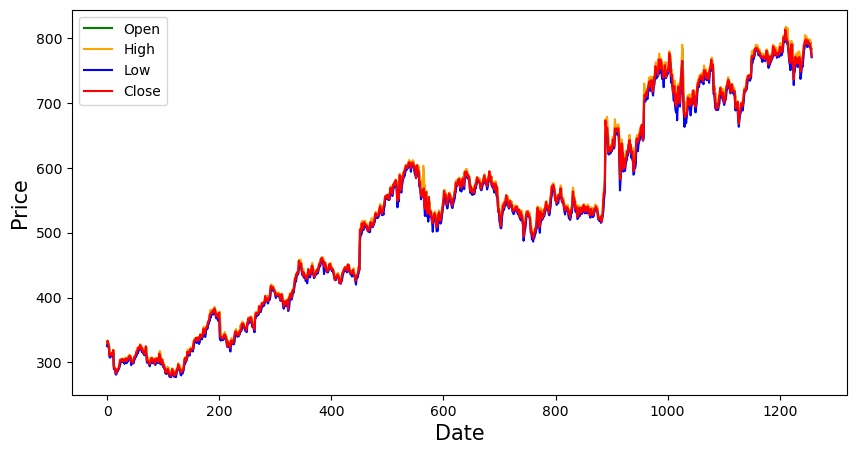

In [204]:
train['Close'] = train.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(train['Open'], label='Open', color='green')
ax.plot(train['High'], label='High', color='orange')
ax.plot(train['Low'],label='Low',color='blue')
ax.plot(train['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

plt.show()


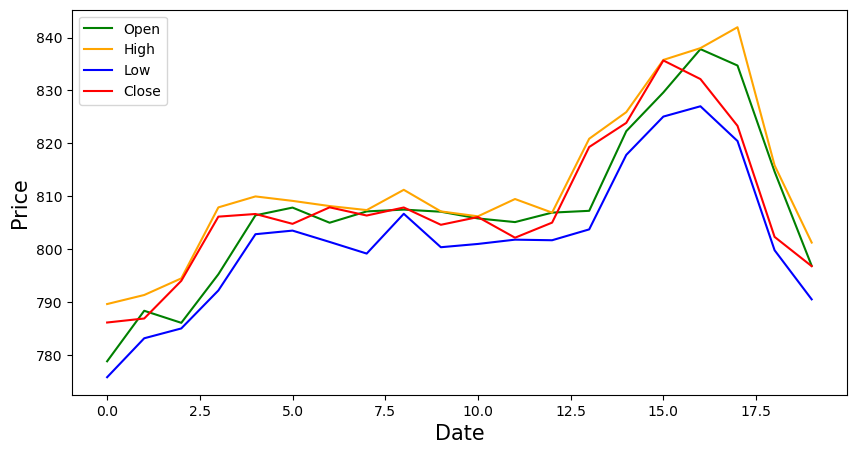

In [205]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(test['Open'], label='Open', color='green')
ax.plot(test['High'], label='High', color='orange')
ax.plot(test['Low'],label='Low',color='blue')
ax.plot(test['Close'],label='Close',color='red')
ax.set_xlabel('Date',size=15)
ax.set_ylabel('Price',size=15)
ax.legend()

plt.show()

3. Prepare train and test data

In [206]:
train = train.iloc[:,1:] #drop date column
test = test.iloc[:,1:]
train

,Open,High,Low,Close,Volume
0,325.25,332.83,324.97,331.795,7380500.0
1,331.27,333.87,329.08,333.225,5749400.0
2,329.83,330.75,326.89,328.605,6590300.0
3,328.34,328.77,323.68,324.120,5405900.0
4,322.04,322.29,309.46,310.380,11688800.0
...,...,...,...,...,...
1253,790.90,792.74,787.28,789.910,623400.0
1254,790.68,797.86,787.66,791.550,789100.0
1255,793.70,794.23,783.20,785.050,1153800.0
1256,783.33,785.93,778.92,782.790,744300.0


In [207]:
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)

In [208]:
train

,Open,High,Low,Close,Volume
0,0.085814,0.096401,0.090449,0.099251,0.295258
1,0.097012,0.098344,0.098235,0.101928,0.229936
2,0.094334,0.092517,0.094086,0.093282,0.263612
3,0.091562,0.088819,0.088006,0.084888,0.216179
4,0.079842,0.076718,0.061070,0.059175,0.467797
...,...,...,...,...,...
1253,0.952043,0.955292,0.966169,0.956583,0.024650
1254,0.951633,0.964853,0.966889,0.959652,0.031286
1255,0.957251,0.958074,0.958441,0.947488,0.045891
1256,0.937960,0.942574,0.950333,0.943258,0.029491


In [209]:
# Create sequences
def create_sequences(data, seq_length):
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data.iloc[i:i+seq_length,:]
        target = data.iloc[i+seq_length,:]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# 4. RNN

In [ ]:


train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]

train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)

train["Close"] = train["Close"].astype(str).str.replace(',', '')

train["Close"] = train["Close"].astype(float)

scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)




In [332]:

split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)


split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)


X_train.shape, y_train.shape

c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


((850, 30, 5), (850, 5))

In [333]:
# Convert to PyTorch tensors
train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)

In [334]:
class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(StockPriceRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # Take the output of the last time step
        return out

In [ ]:
INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 1
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [336]:
# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# # Testing the model
# model.eval()
# with torch.no_grad():
#     predicted = model(X_test).numpy()
#     actual = y_test.numpy()

# predicted = scaler.inverse_transform(predicted)
# actual = scaler.inverse_transform(actual)

# # Plot results
# plt.plot(actual, label="Actual Prices")
# plt.plot(predicted, label="Predicted Prices")
# plt.legend()
# plt.show()

Epoch [10/5000], Train Loss: 0.0433, Validation Loss: 0.1016
Epoch [20/5000], Train Loss: 0.0293, Validation Loss: 0.1222
Epoch [30/5000], Train Loss: 0.0178, Validation Loss: 0.0582
Epoch [40/5000], Train Loss: 0.0104, Validation Loss: 0.0169
Epoch [50/5000], Train Loss: 0.0046, Validation Loss: 0.0184
Epoch [60/5000], Train Loss: 0.0029, Validation Loss: 0.0106
Epoch [70/5000], Train Loss: 0.0023, Validation Loss: 0.0089
Epoch [80/5000], Train Loss: 0.0021, Validation Loss: 0.0095
Epoch [90/5000], Train Loss: 0.0020, Validation Loss: 0.0076
Epoch [100/5000], Train Loss: 0.0019, Validation Loss: 0.0080
Epoch [110/5000], Train Loss: 0.0019, Validation Loss: 0.0075
Epoch [120/5000], Train Loss: 0.0018, Validation Loss: 0.0074
Epoch [130/5000], Train Loss: 0.0018, Validation Loss: 0.0070
Epoch [140/5000], Train Loss: 0.0018, Validation Loss: 0.0068
Epoch [150/5000], Train Loss: 0.0018, Validation Loss: 0.0066
Epoch [160/5000], Train Loss: 0.0018, Validation Loss: 0.0064
Epoch [170/5000],

In [337]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)



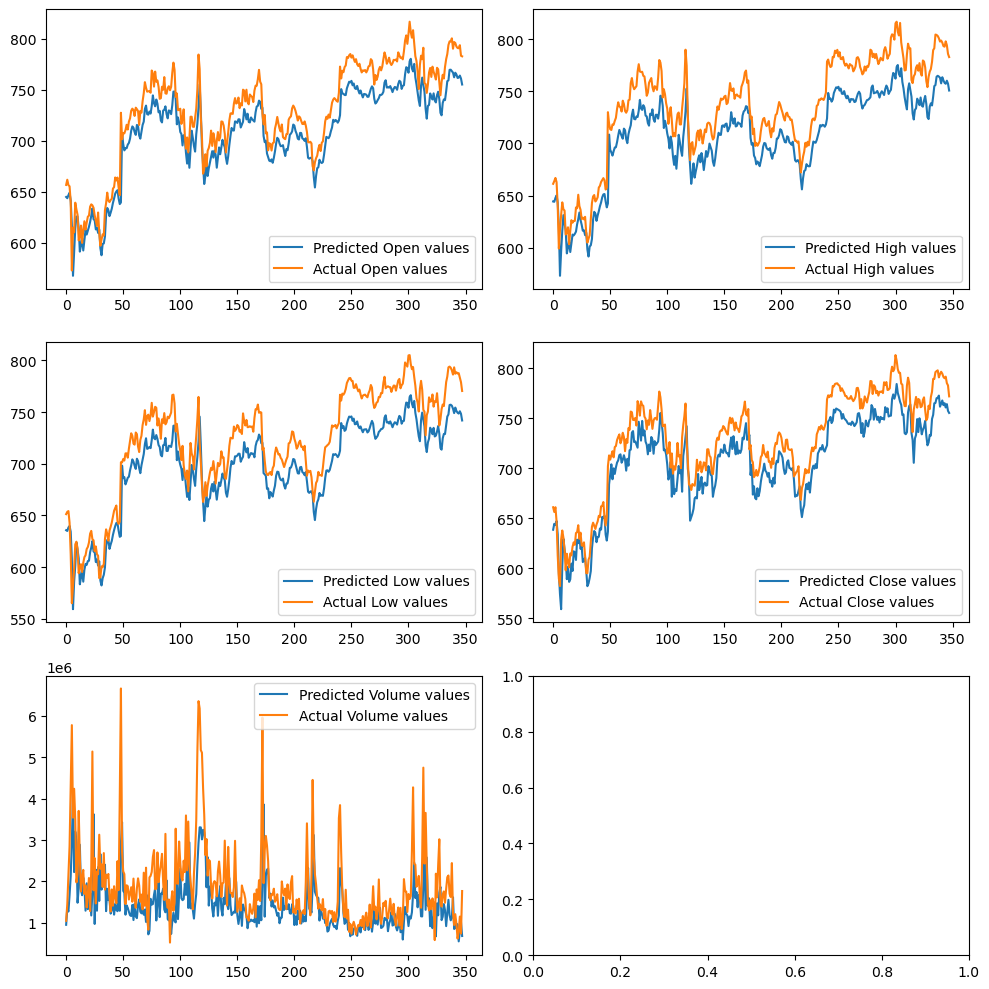

In [338]:


fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [339]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 160831470000.0
R² Score: 0.6039789915084839
RMSE: 179370.4


# 5. LSTM

In [483]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]

# converting str to str and replacing commas with None:
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')

# Converting str to float
train["Volume"] = train["Volume"].astype(float)

# converting str to str and replacing commas with None:
train["Close"] = train["Close"].astype(str).str.replace(',', '')

# Converting str to float
train["Close"] = train["Close"].astype(float)

scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


In [484]:

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)

#_-------------
split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)

X_train.shape, y_train.shape

c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


((850, 30, 5), (850, 5))

In [485]:
train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)

In [ ]:

INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 5

class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out
model = LSTM(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


In [487]:
# # model = LSTMModel(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)

# # # Loss and optimizer
# # criterion = nn.MSELoss()
# # optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# model = LSTMModel(5, 50, 2, 5)
# criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# prev_loss = float('inf')
# # Training the model
best_model = None
lowest_val_loss = float('inf')
EPOCHS = 3000
for epoch in range(EPOCHS):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

   # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(valid_data)
        val_loss = criterion(val_outputs, valid_target)
    
    # if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
    #     break
    # elif val_loss.item() < prev_loss:
    #     prev_loss = val_loss.item()
    if lowest_val_loss > val_loss.item():
        lowest_val_loss = val_loss.item()
        best_model = model
    
    val_loss = val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')

# EPOCHS = 5000
# for epoch in range(1000):
#     # Training step
#     model.train()
#     outputs = model(train_data)
#     train_loss = criterion(outputs, train_target)
#     optimizer.zero_grad()
#     train_loss.backward()
#     optimizer.step()

#     if (epoch + 1) % 10 == 0:
#         print(f'Epoch [{epoch+1}/{1000}], Train Loss: {train_loss.item():.4f}')


Epoch [10/3000], Train Loss: 0.0014, Validation Loss: 0.3193
Epoch [20/3000], Train Loss: 0.0014, Validation Loss: 0.0857
Epoch [30/3000], Train Loss: 0.0014, Validation Loss: 0.0588
Epoch [40/3000], Train Loss: 0.0014, Validation Loss: 0.0800
Epoch [50/3000], Train Loss: 0.0014, Validation Loss: 0.0528
Epoch [60/3000], Train Loss: 0.0014, Validation Loss: 0.0596
Epoch [70/3000], Train Loss: 0.0014, Validation Loss: 0.0595
Epoch [80/3000], Train Loss: 0.0014, Validation Loss: 0.0489
Epoch [90/3000], Train Loss: 0.0014, Validation Loss: 0.0470
Epoch [100/3000], Train Loss: 0.0014, Validation Loss: 0.0435
Epoch [110/3000], Train Loss: 0.0014, Validation Loss: 0.0414
Epoch [120/3000], Train Loss: 0.0014, Validation Loss: 0.0394
Epoch [130/3000], Train Loss: 0.0014, Validation Loss: 0.0371
Epoch [140/3000], Train Loss: 0.0014, Validation Loss: 0.0352
Epoch [150/3000], Train Loss: 0.0014, Validation Loss: 0.0337
Epoch [160/3000], Train Loss: 0.0014, Validation Loss: 0.0323
Epoch [170/3000],

In [488]:
# Testing the model
model = best_model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

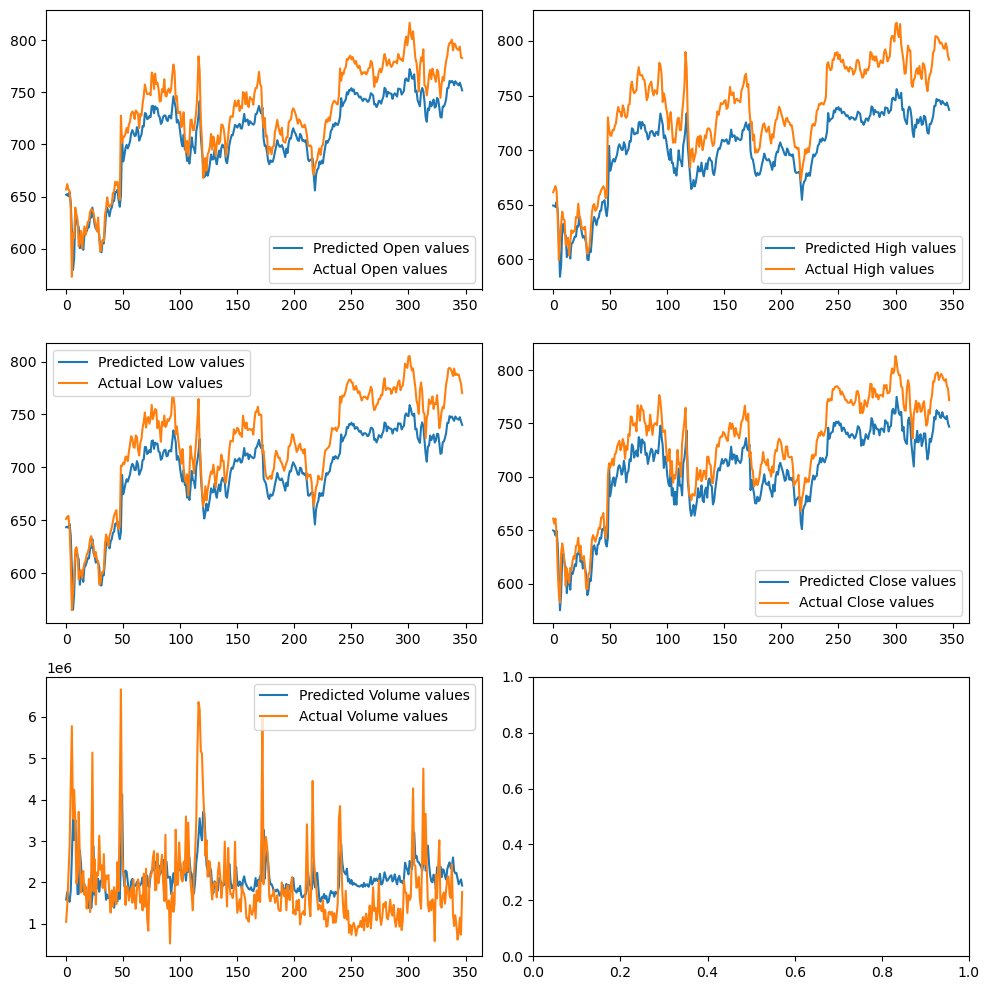

In [489]:


fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [490]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 151021450000.0
R² Score: 0.5530968904495239
RMSE: 173817.0


# Fine tune RNN

### (a) learning rate (0.01)

In [491]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [492]:
INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/5000], Train Loss: 0.0129, Validation Loss: 0.0178
Epoch [20/5000], Train Loss: 0.0032, Validation Loss: 0.0116
Epoch [30/5000], Train Loss: 0.0018, Validation Loss: 0.0089
Epoch [40/5000], Train Loss: 0.0017, Validation Loss: 0.0078
Epoch [50/5000], Train Loss: 0.0015, Validation Loss: 0.0063
Epoch [60/5000], Train Loss: 0.0013, Validation Loss: 0.0056
Epoch [70/5000], Train Loss: 0.0013, Validation Loss: 0.0053
Epoch [80/5000], Train Loss: 0.0012, Validation Loss: 0.0050
Epoch [90/5000], Train Loss: 0.0012, Validation Loss: 0.0046
Epoch [100/5000], Train Loss: 0.0012, Validation Loss: 0.0043
Epoch [110/5000], Train Loss: 0.0011, Validation Loss: 0.0040
Epoch [120/5000], Train Loss: 0.0011, Validation Loss: 0.0038
Epoch [130/5000], Train Loss: 0.0011, Validation Loss: 0.0037
Epoch [140/5000], Train Loss: 0.0011, Validation Loss: 0.0035
Epoch [150/5000], Train Loss: 0.0011, Validation Loss: 0.0034
Epoch [160/5000], Train Loss: 0.0011, Validation Loss: 0.0033
Epoch [170/5000],

In [493]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)



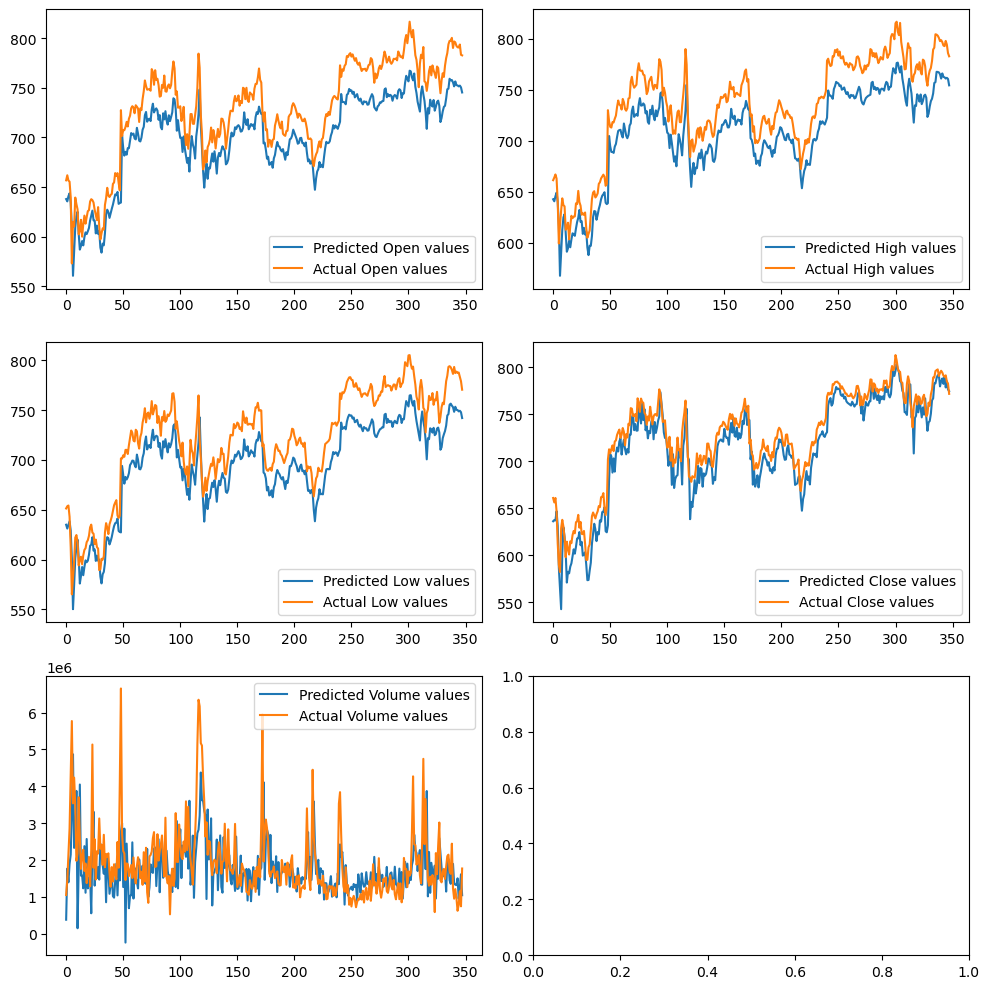

In [494]:


fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [495]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 152490770000.0
R² Score: 0.5930328965187073
RMSE: 174658.69


 (b) HIDDEN_SIZE = 60

In [499]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [500]:
INPUT_SIZE = 5
HIDDEN_SIZE = 60
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/5000], Train Loss: 0.0241, Validation Loss: 0.0605
Epoch [20/5000], Train Loss: 0.0048, Validation Loss: 0.0176
Epoch [30/5000], Train Loss: 0.0022, Validation Loss: 0.0065
Epoch [40/5000], Train Loss: 0.0016, Validation Loss: 0.0080
Epoch [50/5000], Train Loss: 0.0016, Validation Loss: 0.0055
Epoch [60/5000], Train Loss: 0.0014, Validation Loss: 0.0045
Epoch [70/5000], Train Loss: 0.0013, Validation Loss: 0.0043
Epoch [80/5000], Train Loss: 0.0013, Validation Loss: 0.0047
Epoch [90/5000], Train Loss: 0.0013, Validation Loss: 0.0042
Epoch [100/5000], Train Loss: 0.0012, Validation Loss: 0.0039
Epoch [110/5000], Train Loss: 0.0012, Validation Loss: 0.0038
Epoch [120/5000], Train Loss: 0.0012, Validation Loss: 0.0037
Epoch [130/5000], Train Loss: 0.0012, Validation Loss: 0.0035
Epoch [140/5000], Train Loss: 0.0012, Validation Loss: 0.0034
Epoch [150/5000], Train Loss: 0.0012, Validation Loss: 0.0033
Epoch [160/5000], Train Loss: 0.0012, Validation Loss: 0.0032
Epoch [170/5000],

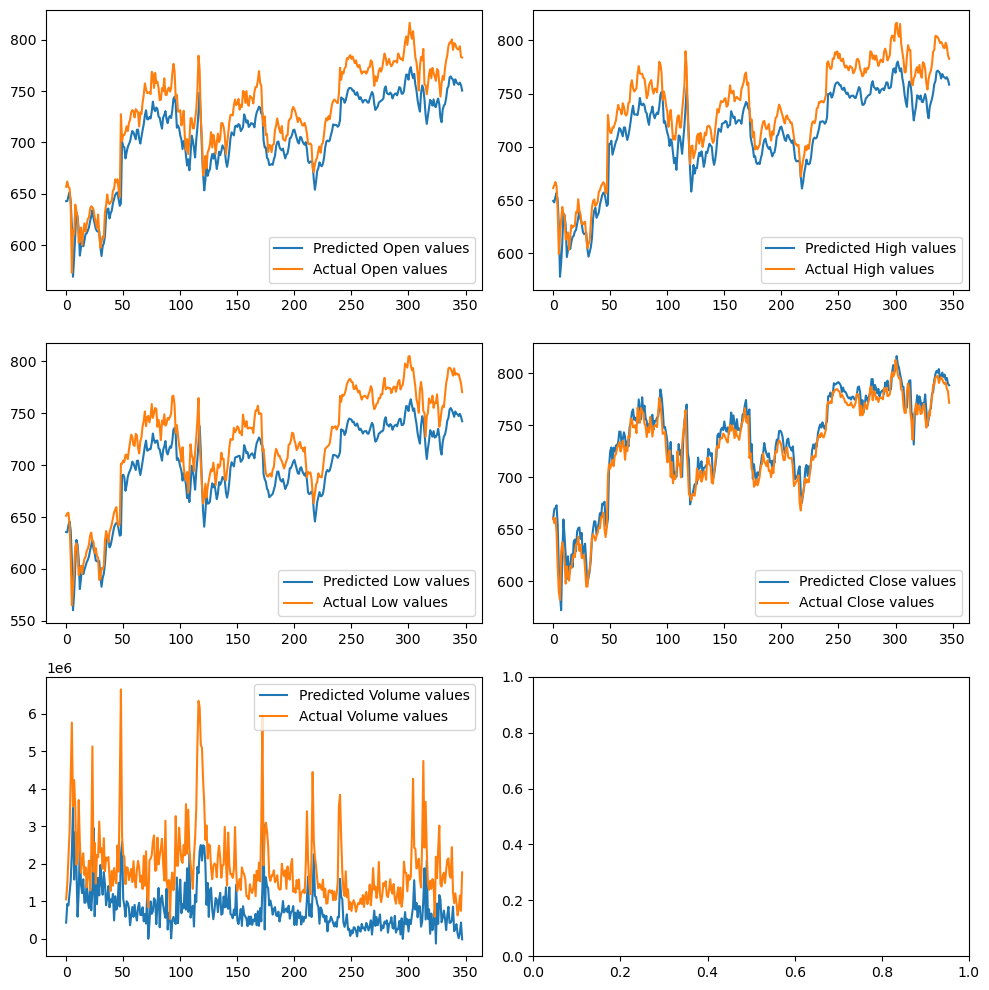

In [501]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [502]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 367600440000.0
R² Score: 0.4185970723628998
RMSE: 271164.03


HIDDEN_SIZE = 70

In [515]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [516]:
INPUT_SIZE = 5
HIDDEN_SIZE = 70
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/5000], Train Loss: 0.0144, Validation Loss: 0.0368
Epoch [20/5000], Train Loss: 0.0116, Validation Loss: 0.0586
Epoch [30/5000], Train Loss: 0.0046, Validation Loss: 0.0245
Epoch [40/5000], Train Loss: 0.0021, Validation Loss: 0.0079
Epoch [50/5000], Train Loss: 0.0018, Validation Loss: 0.0050
Epoch [60/5000], Train Loss: 0.0016, Validation Loss: 0.0051
Epoch [70/5000], Train Loss: 0.0014, Validation Loss: 0.0054
Epoch [80/5000], Train Loss: 0.0014, Validation Loss: 0.0046
Epoch [90/5000], Train Loss: 0.0013, Validation Loss: 0.0045
Epoch [100/5000], Train Loss: 0.0013, Validation Loss: 0.0047
Epoch [110/5000], Train Loss: 0.0012, Validation Loss: 0.0045
Epoch [120/5000], Train Loss: 0.0012, Validation Loss: 0.0043
Epoch [130/5000], Train Loss: 0.0012, Validation Loss: 0.0042
Epoch [140/5000], Train Loss: 0.0012, Validation Loss: 0.0041
Epoch [150/5000], Train Loss: 0.0011, Validation Loss: 0.0039
Epoch [160/5000], Train Loss: 0.0011, Validation Loss: 0.0038
Epoch [170/5000],

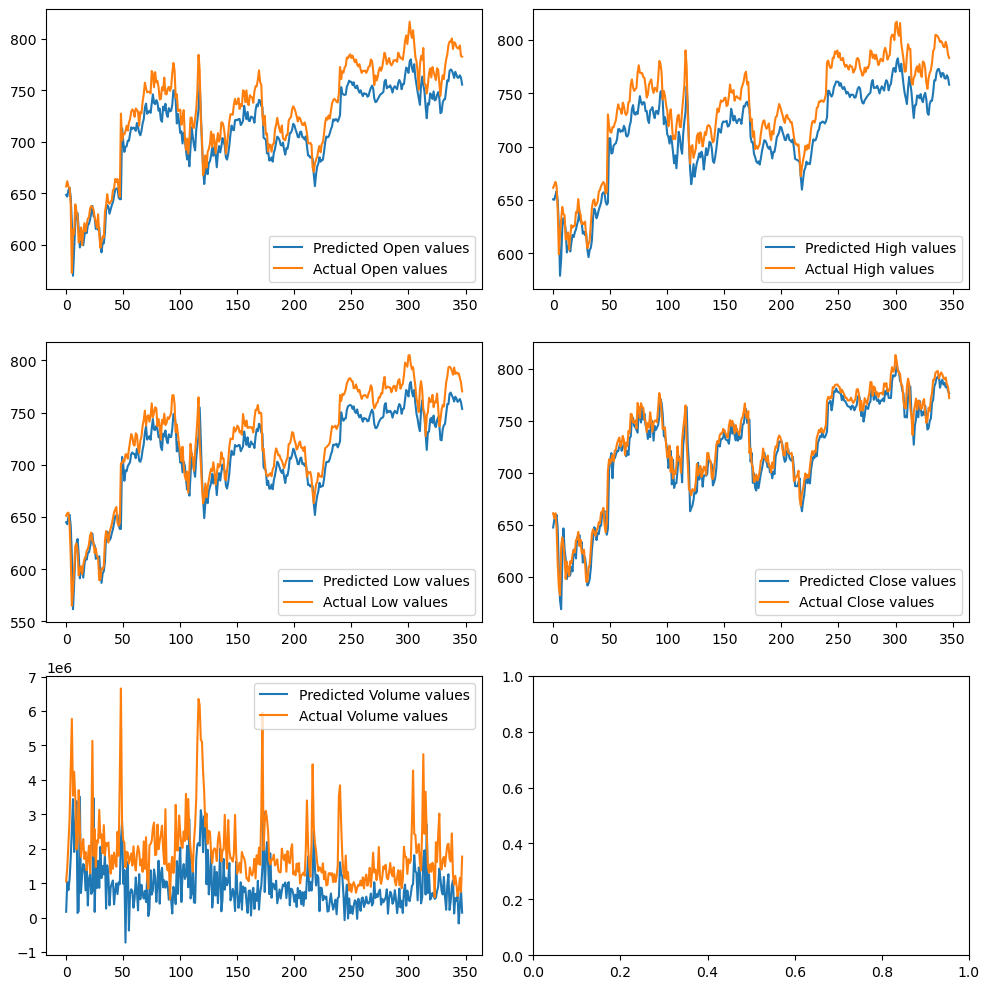

In [517]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [518]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 342794100000.0
R² Score: 0.49830570816993713
RMSE: 261852.66


HIDDEN_SIZE = 40

In [519]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,30)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,30)
X_test, y_test = create_sequences(test_scaled,30)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [520]:
INPUT_SIZE = 5
HIDDEN_SIZE = 40
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/5000], Train Loss: 0.0191, Validation Loss: 0.0193
Epoch [20/5000], Train Loss: 0.0055, Validation Loss: 0.0067
Epoch [30/5000], Train Loss: 0.0028, Validation Loss: 0.0091
Epoch [40/5000], Train Loss: 0.0021, Validation Loss: 0.0047
Epoch [50/5000], Train Loss: 0.0017, Validation Loss: 0.0035
Epoch [60/5000], Train Loss: 0.0015, Validation Loss: 0.0035
Epoch [70/5000], Train Loss: 0.0014, Validation Loss: 0.0039
Epoch [80/5000], Train Loss: 0.0014, Validation Loss: 0.0033
Epoch [90/5000], Train Loss: 0.0014, Validation Loss: 0.0031
Epoch [100/5000], Train Loss: 0.0013, Validation Loss: 0.0030
Epoch [110/5000], Train Loss: 0.0013, Validation Loss: 0.0029
Epoch [120/5000], Train Loss: 0.0013, Validation Loss: 0.0027
Epoch [130/5000], Train Loss: 0.0012, Validation Loss: 0.0026
Epoch [140/5000], Train Loss: 0.0012, Validation Loss: 0.0025
Epoch [150/5000], Train Loss: 0.0012, Validation Loss: 0.0024
Epoch [160/5000], Train Loss: 0.0012, Validation Loss: 0.0023
Epoch [170/5000],

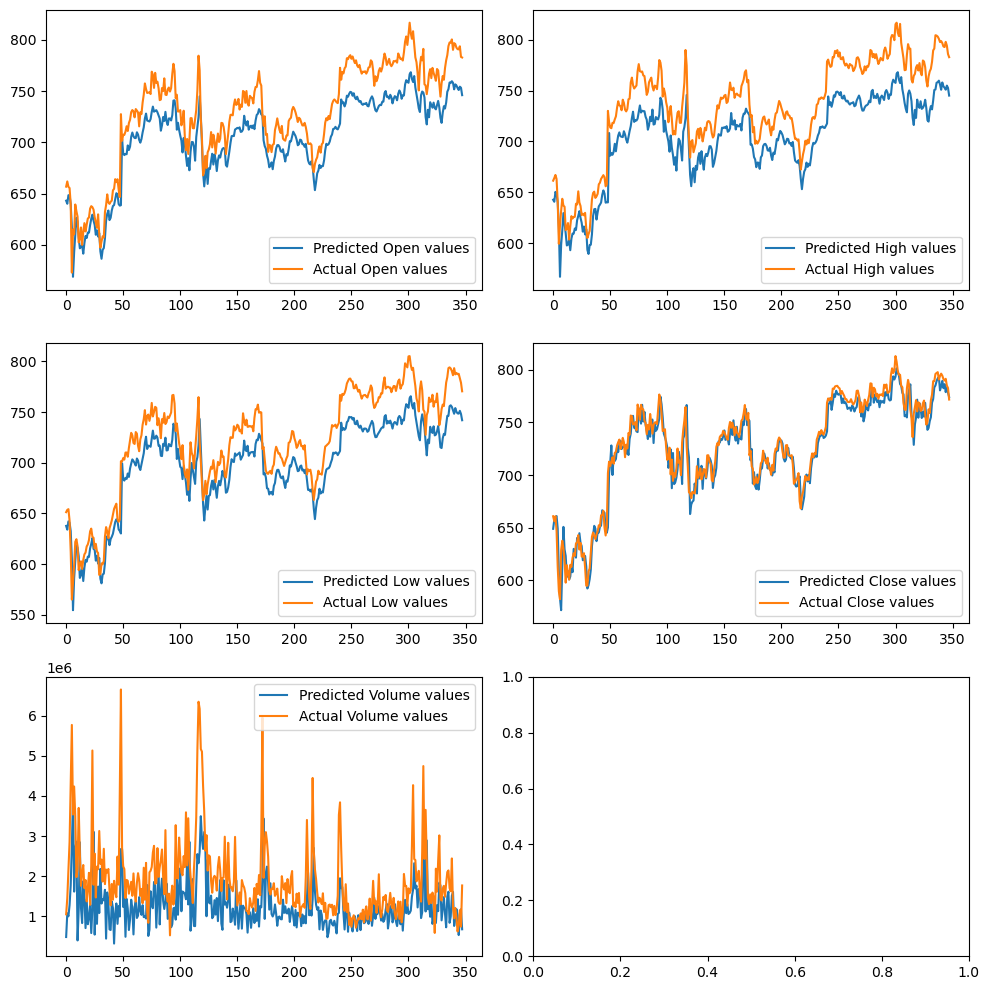

In [521]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

In [522]:
mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)

Mean Squared Error: 214740960000.0
R² Score: 0.5414113998413086
RMSE: 207259.45


(c) SEQUENCE_LEN = 60

In [ ]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,60)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,60)
X_test, y_test = create_sequences(test_scaled,60)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [527]:
INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 5000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/5000], Train Loss: 0.0115, Validation Loss: 0.0061
Epoch [20/5000], Train Loss: 0.0045, Validation Loss: 0.0052
Epoch [30/5000], Train Loss: 0.0025, Validation Loss: 0.0086
Epoch [40/5000], Train Loss: 0.0017, Validation Loss: 0.0068
Epoch [50/5000], Train Loss: 0.0015, Validation Loss: 0.0044
Epoch [60/5000], Train Loss: 0.0015, Validation Loss: 0.0043
Epoch [70/5000], Train Loss: 0.0015, Validation Loss: 0.0041
Epoch [80/5000], Train Loss: 0.0014, Validation Loss: 0.0041
Epoch [90/5000], Train Loss: 0.0014, Validation Loss: 0.0040
Epoch [100/5000], Train Loss: 0.0013, Validation Loss: 0.0038
Epoch [110/5000], Train Loss: 0.0013, Validation Loss: 0.0036
Epoch [120/5000], Train Loss: 0.0013, Validation Loss: 0.0034
Epoch [130/5000], Train Loss: 0.0012, Validation Loss: 0.0032
Epoch [140/5000], Train Loss: 0.0012, Validation Loss: 0.0031
Epoch [150/5000], Train Loss: 0.0012, Validation Loss: 0.0029
Epoch [160/5000], Train Loss: 0.0012, Validation Loss: 0.0028
Epoch [170/5000],

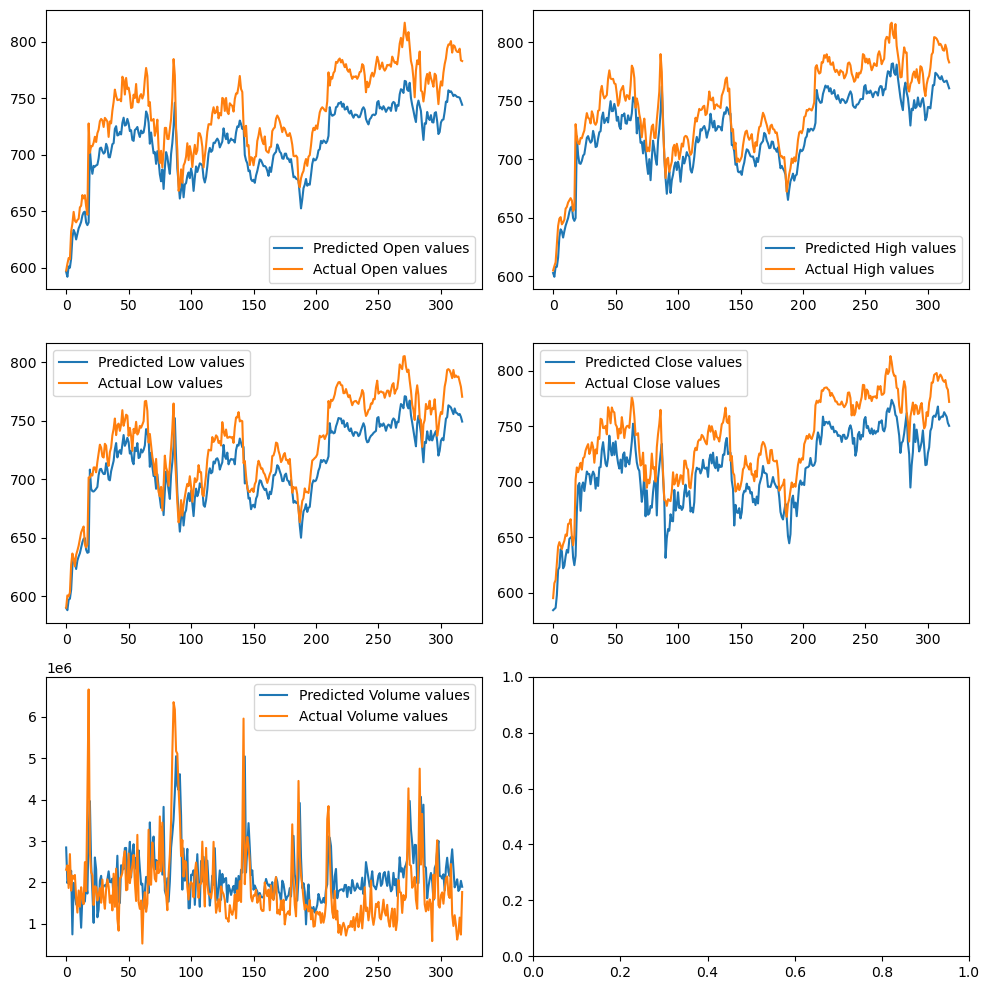

Mean Squared Error: 136218690000.0
R² Score: 0.4847172796726227
RMSE: 165077.72


In [528]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)


SEQUENCE_LEN = 20

In [543]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,20)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,20)
X_test, y_test = create_sequences(test_scaled,20)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [544]:
INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 3000
prev_loss = float('inf')
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.001) and epoch > 1000:
        break
    elif val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/3000], Train Loss: 0.0176, Validation Loss: 0.0391
Epoch [20/3000], Train Loss: 0.0080, Validation Loss: 0.0126
Epoch [30/3000], Train Loss: 0.0057, Validation Loss: 0.0015
Epoch [40/3000], Train Loss: 0.0049, Validation Loss: 0.0043
Epoch [50/3000], Train Loss: 0.0040, Validation Loss: 0.0042
Epoch [60/3000], Train Loss: 0.0038, Validation Loss: 0.0025
Epoch [70/3000], Train Loss: 0.0035, Validation Loss: 0.0025
Epoch [80/3000], Train Loss: 0.0033, Validation Loss: 0.0023
Epoch [90/3000], Train Loss: 0.0032, Validation Loss: 0.0020
Epoch [100/3000], Train Loss: 0.0029, Validation Loss: 0.0018
Epoch [110/3000], Train Loss: 0.0030, Validation Loss: 0.0018
Epoch [120/3000], Train Loss: 0.0027, Validation Loss: 0.0014
Epoch [130/3000], Train Loss: 0.0027, Validation Loss: 0.0019
Epoch [140/3000], Train Loss: 0.0026, Validation Loss: 0.0013
Epoch [150/3000], Train Loss: 0.0027, Validation Loss: 0.0012
Epoch [160/3000], Train Loss: 0.0024, Validation Loss: 0.0017
Epoch [170/3000],

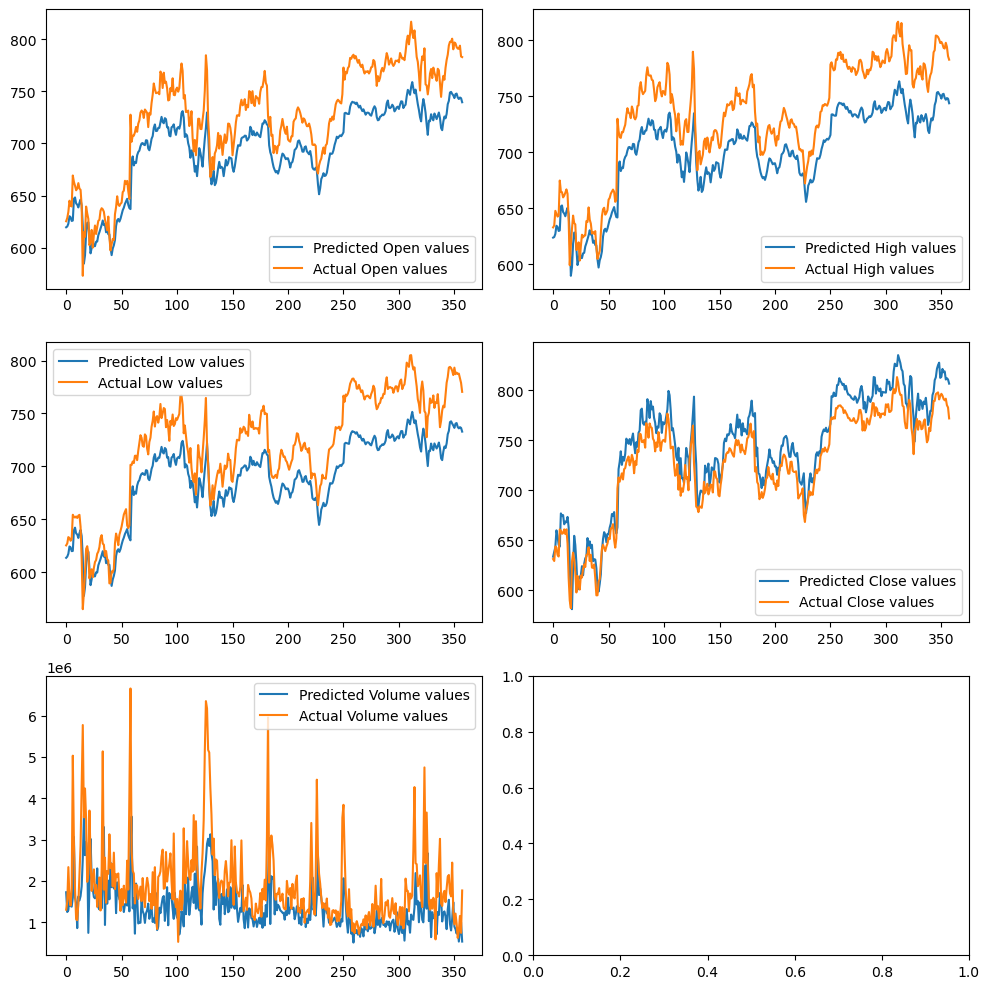

Mean Squared Error: 182971740000.0
R² Score: 0.4875124990940094
RMSE: 191321.62


In [545]:

# Testing the model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)


(e) Stacked RNN

In [562]:

import torch
import torch.nn as nn

class StockPriceRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout_rate=0.2):
        super(StockPriceRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # RNN layers with one extra RNN layer and Dropout
        self.rnn1 = nn.RNN(input_size, hidden_size, 1, batch_first=True)
        self.rnn2 = nn.RNN(hidden_size, hidden_size, 1, batch_first=True)
        self.dropout = nn.Dropout(dropout_rate)

        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Forward through first RNN layer
        out, _ = self.rnn1(x)
        out = self.dropout(out)  # Apply dropout after first RNN
        
        # Forward through second RNN layer
        out, _ = self.rnn2(out)
        out = self.dropout(out)  # Apply dropout after second RNN
        
        # Use the last time step for final output
        out = self.fc(out[:, -1, :])
        return out


In [563]:

train = pd.read_csv('archive/Google_Stock_Price_Train.csv',parse_dates=True)
train = train.iloc[:,1:]
train["Volume"] = train["Volume"].astype(str).str.replace(',', '')
train["Volume"] = train["Volume"].astype(float)
train["Close"] = train["Close"].astype(str).str.replace(',', '')
train["Close"] = train["Close"].astype(float)
scaler = MinMaxScaler()
train[train.columns] = scaler.fit_transform(train)


split_data = np.split(train, [int(.7*len(train)), int(.85*len(train))])
_, _, valid_scaled = [d for d in split_data]
X_valid, y_valid = create_sequences(valid_scaled,20)

split_data = np.split(train, [int(.7*len(train))])
train_scaled, test_scaled = [d for d in split_data]
X_train, y_train = create_sequences(train_scaled,20)
X_test, y_test = create_sequences(test_scaled,20)

train_data = torch.Tensor(X_train)
train_target = torch.Tensor(y_train)
valid_data = torch.Tensor(X_valid)
valid_target = torch.Tensor(y_valid)
test_data = torch.Tensor(X_test)
test_target = torch.Tensor(y_test)


c:\Users\ASUS\.conda\envs\myenv\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [564]:
INPUT_SIZE = 5
HIDDEN_SIZE = 50
NUM_LAYERS = 2
OUTPUT_SIZE = 5

model = StockPriceRNN(INPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, OUTPUT_SIZE)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training the model
EPOCHS = 2000
prev_loss = float('inf')
best_model = None
for epoch in range(EPOCHS):
    # Training step
    model.train()
    outputs = model(train_data)
    train_loss = criterion(outputs, train_target)
    optimizer.zero_grad()
    train_loss.backward()
    optimizer.step()

    # Validation step
    model.eval()
    with torch.no_grad():
        val_outputs = model(test_data)
        val_loss = criterion(val_outputs, test_target)
    # if val_loss.item() > prev_loss and abs(val_loss.item() - prev_loss > 0.01) and epoch > 1000:
    #     break
    if val_loss.item() < prev_loss:
        prev_loss = val_loss.item()
        best_model = model
    val_loss= val_loss.item()
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{EPOCHS}], Train Loss: {train_loss.item():.4f}, Validation Loss: {val_loss:.4f}')




Epoch [10/2000], Train Loss: 0.0255, Validation Loss: 0.0179
Epoch [20/2000], Train Loss: 0.0075, Validation Loss: 0.0106
Epoch [30/2000], Train Loss: 0.0051, Validation Loss: 0.0044
Epoch [40/2000], Train Loss: 0.0041, Validation Loss: 0.0047
Epoch [50/2000], Train Loss: 0.0036, Validation Loss: 0.0025
Epoch [60/2000], Train Loss: 0.0032, Validation Loss: 0.0027
Epoch [70/2000], Train Loss: 0.0031, Validation Loss: 0.0025
Epoch [80/2000], Train Loss: 0.0029, Validation Loss: 0.0021
Epoch [90/2000], Train Loss: 0.0028, Validation Loss: 0.0019
Epoch [100/2000], Train Loss: 0.0028, Validation Loss: 0.0023
Epoch [110/2000], Train Loss: 0.0026, Validation Loss: 0.0018
Epoch [120/2000], Train Loss: 0.0026, Validation Loss: 0.0018
Epoch [130/2000], Train Loss: 0.0025, Validation Loss: 0.0020
Epoch [140/2000], Train Loss: 0.0023, Validation Loss: 0.0024
Epoch [150/2000], Train Loss: 0.0023, Validation Loss: 0.0020
Epoch [160/2000], Train Loss: 0.0023, Validation Loss: 0.0019
Epoch [170/2000],

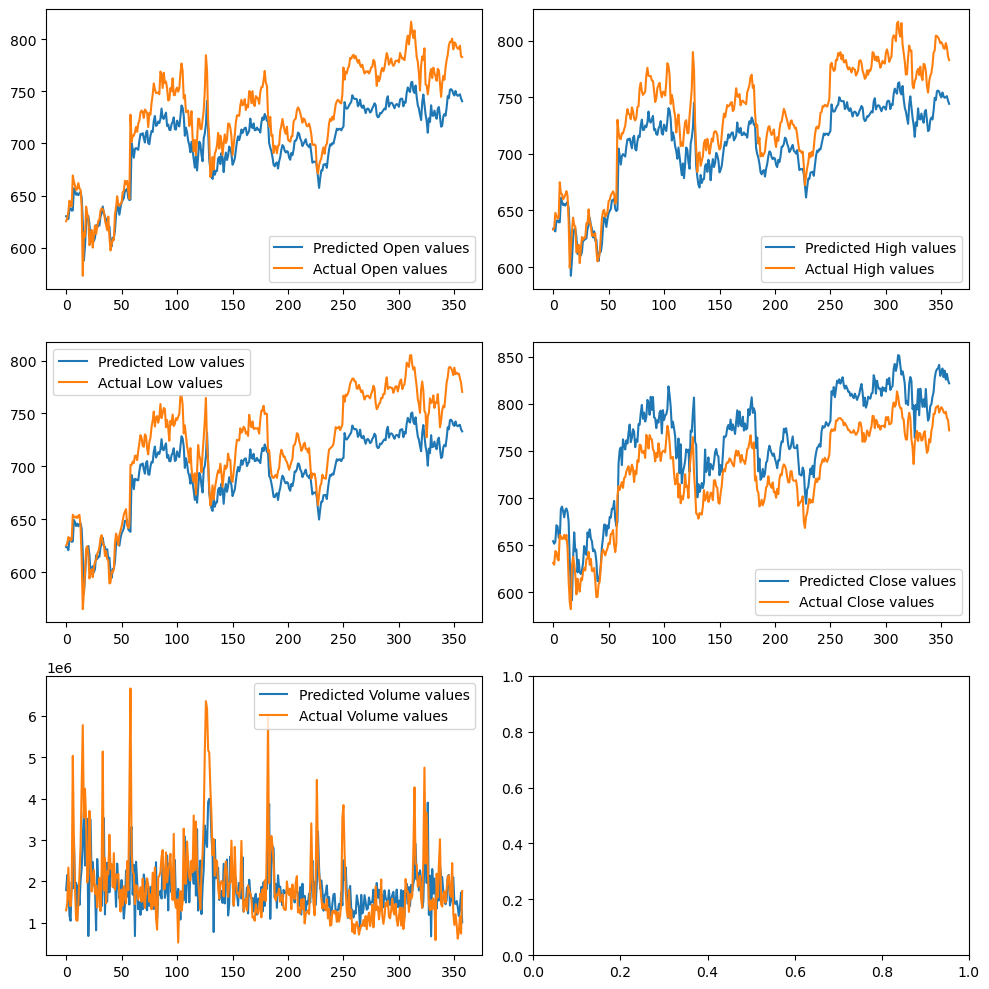

Mean Squared Error: 136674870000.0
R² Score: 0.5316343903541565
RMSE: 165358.67


In [565]:

# Testing the model
model = best_model
model.eval()
with torch.no_grad():
    predicted = model(test_data).numpy()
    actual = test_target.numpy()

predicted = scaler.inverse_transform(predicted)
actual = scaler.inverse_transform(actual)

fig, axes = plt.subplots(3, 2, figsize=(10, 10))

axes[0,0].plot(predicted[:,0], label='Predicted Open values')
axes[0,0].plot(actual[:,0], label='Actual Open values')
axes[0,0].legend()

axes[0,1].plot(predicted[:,1], label='Predicted High values')
axes[0,1].plot(actual[:,1], label='Actual High values')
axes[0,1].legend()

axes[1,0].plot(predicted[:,2], label='Predicted Low values')
axes[1,0].plot(actual[:,2], label='Actual Low values')
axes[1,0].legend()

axes[1,1].plot(predicted[:,3], label='Predicted Close values')
axes[1,1].plot(actual[:,3], label='Actual Close values')
axes[1,1].legend()

axes[2,0].plot(predicted[:,4], label='Predicted Volume values')
axes[2,0].plot(actual[:,4], label='Actual Volume values')
axes[2,0].legend()

plt.tight_layout()
plt.show()

mse = mean_squared_error(actual, predicted)
print("Mean Squared Error:", mse)

r2 = r2_score(actual, predicted)
print("R² Score:", r2)

rmse = root_mean_squared_error(actual, predicted)
print("RMSE:", rmse)
